In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [4]:
import json
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O ./sarcasm.json

vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


with open("./sarcasm.json", 'r') as f:
    datastore = json.load(f)


sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = np.array(pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = np.array(pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type))

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 50
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)


--2020-06-10 17:10:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.160.240, 2404:6800:4002:80b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.160.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘./sarcasm.json’

./sarcasm.json      100%[===================>]   5.38M   527KB/s    in 7.9s    

2020-06-10 17:10:33 (701 KB/s) - ‘./sarcasm.json’ saved [5643545/5643545]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 128)          10368     
_____________

625/625 [==============================] - 20s 32ms/step - loss: 0.0168 - accuracy: 0.9919 - val_loss: 2.5985 - val_accuracy: 0.7892
Epoch 47/50
625/625 [==============================] - 19s 31ms/step - loss: 0.0171 - accuracy: 0.9920 - val_loss: 2.6304 - val_accuracy: 0.7904
Epoch 48/50
625/625 [==============================] - 21s 34ms/step - loss: 0.0233 - accuracy: 0.9894 - val_loss: 2.6212 - val_accuracy: 0.7870
Epoch 49/50
625/625 [==============================] - 23s 37ms/step - loss: 0.0253 - accuracy: 0.9895 - val_loss: 2.4597 - val_accuracy: 0.7904
Epoch 50/50
625/625 [==============================] - 21s 33ms/step - loss: 0.0219 - accuracy: 0.9899 - val_loss: 2.5531 - val_accuracy: 0.7918


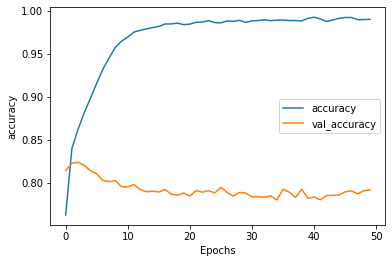

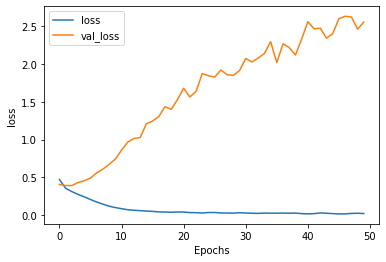

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [6]:
model.save("test_conv.h5")